0it [00:00, ?it/s]

Total files: 105829
Total unique speakers: 2618


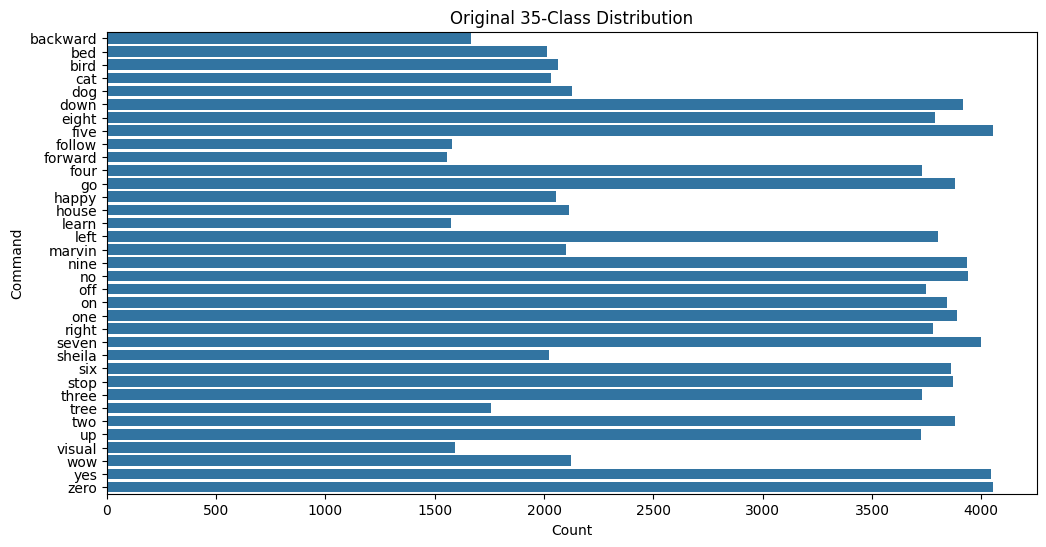

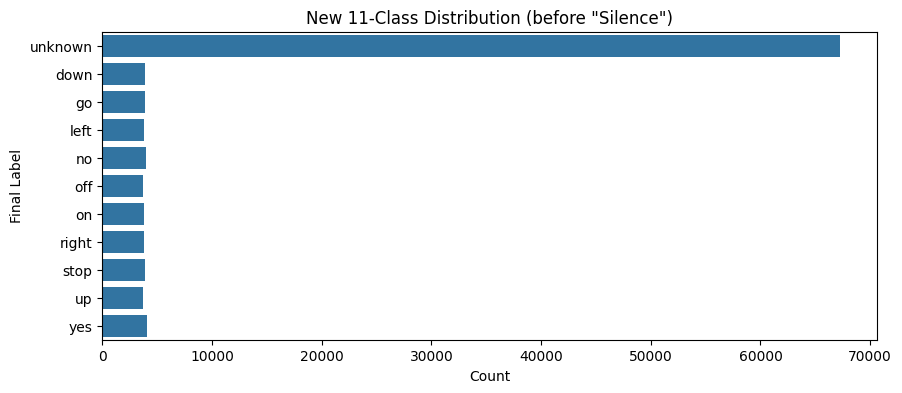

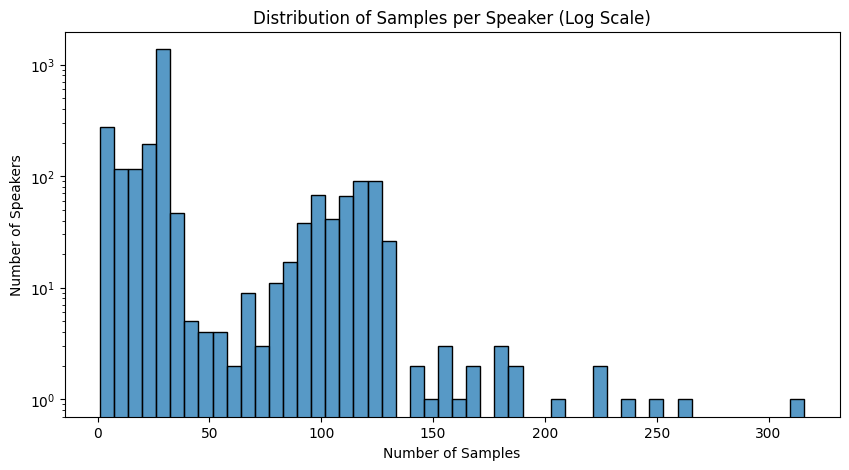

count    2618.000000
mean       40.423606
std        36.915312
min         1.000000
25%        25.000000
50%        30.000000
75%        30.000000
max       316.000000
Name: count, dtype: float64
Running full feature extraction on all files


  0%|          | 0/105829 [00:00<?, ?it/s]

Processed 105829 speech files.
Generating 3854 silence samples...


  0%|          | 0/3854 [00:00<?, ?it/s]

Generating EDA Plot 3: Feature Distribution by Class (Boxplots)


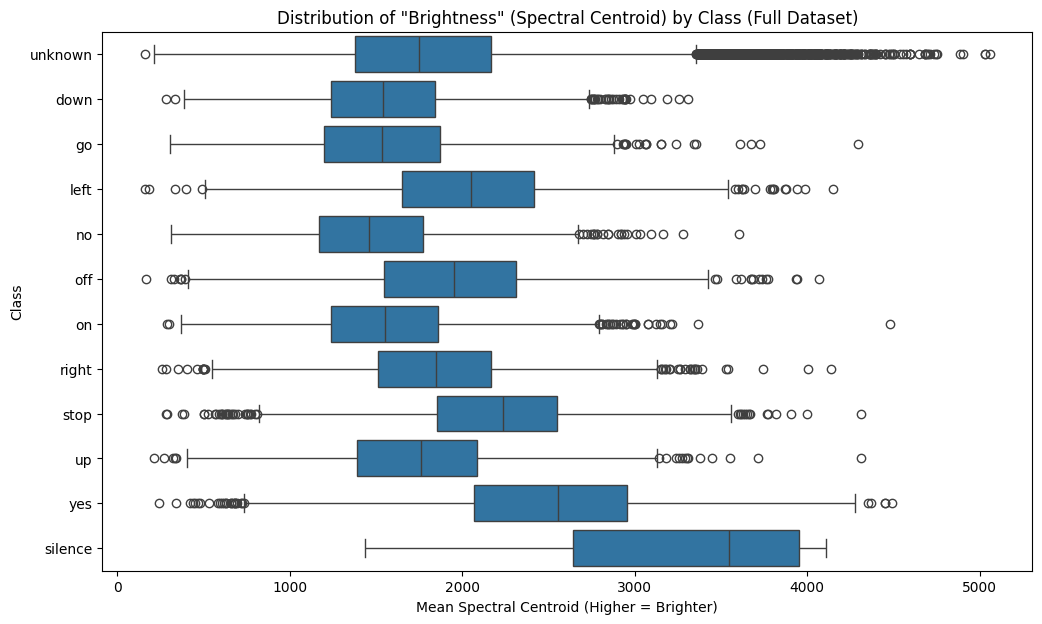

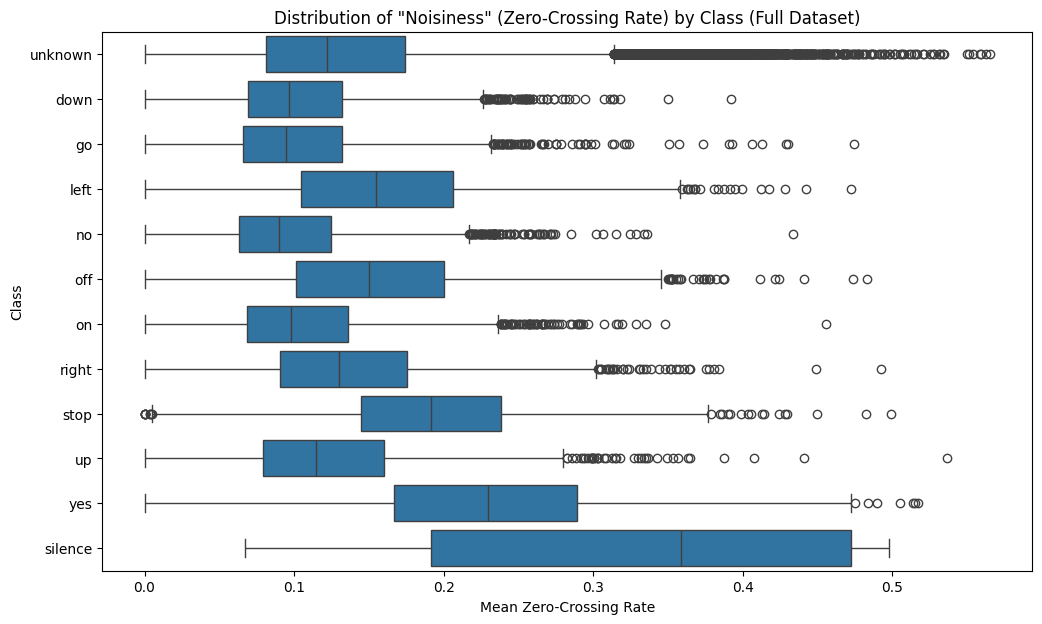

Generating EDA Plot 4: Feature Correlation Heatmap


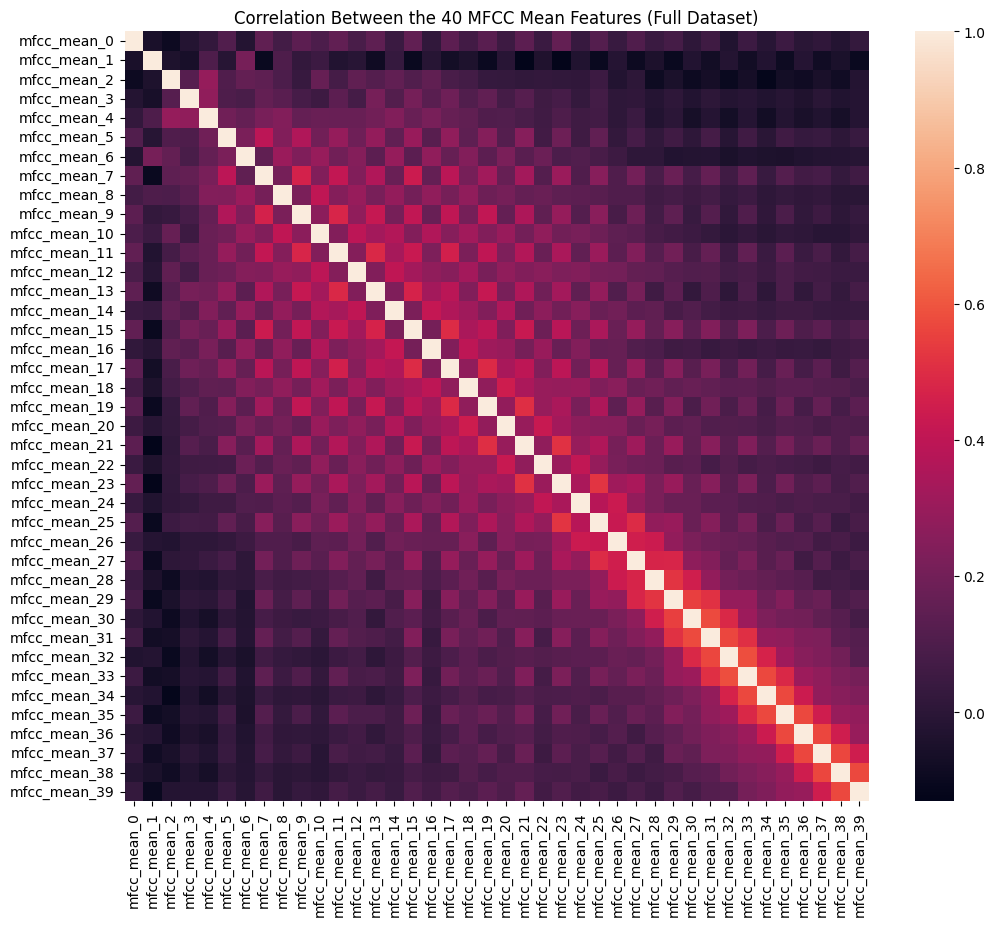

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import shutil
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

TARGET_SR = 16000

# load
DATA_PATH = Path('./data/speech_commands/')
all_filepaths = []
for f in tqdm(DATA_PATH.glob('**/*.wav')):
    if '_background_noise_' not in str(f):
        all_filepaths.append(str(f))

df = pd.DataFrame(all_filepaths, columns=['file_path'])
df['label'] = df['file_path'].apply(lambda x: Path(x).parent.name)
df['speaker_id'] = df['file_path'].apply(lambda x: Path(x).name.split('_')[0])

print(f"Total files: {len(df)}")
print(f"Total unique speakers: {df['speaker_id'].nunique()}")

# Relabeling and Strategy (simplifies the problem from 35 classes down to 11)
CORE_CLASSES = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

def relabel(label):
    if label in CORE_CLASSES:
        return label
    else:
        return 'unknown'

df['final_label'] = df['label'].apply(relabel)

# EDA figures
# 35-Class Distribution
plt.figure(figsize=(12, 6))
sns.countplot(y=df['label'])
plt.title('Original 35-Class Distribution')
plt.xlabel('Count')
plt.ylabel('Command')
plt.show()

# 11-Class Distribution
plt.figure(figsize=(10, 4))
sns.countplot(y=df['final_label'])
plt.title('New 11-Class Distribution (before "Silence")')
plt.xlabel('Count')
plt.ylabel('Final Label')
plt.show()

# Samples per Speaker
speaker_counts = df['speaker_id'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(speaker_counts, bins=50)
plt.title('Distribution of Samples per Speaker (Log Scale)')
plt.xlabel('Number of Samples')
plt.ylabel('Number of Speakers')
plt.yscale('log')
plt.show()
print(speaker_counts.describe())

# Define Feature Extraction Functions
def extract_features(file_path: str, sr: int = TARGET_SR) -> np.ndarray:
    """Extracts 84 features from a single audio file."""
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=1.0)
        if len(y) < sr:
            y = librosa.util.fix_length(y, size=sr)
        elif len(y) > sr:
            y = y[:sr]
        
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)
        spec_centroid_mean = np.mean(spec_centroid)
        spec_centroid_std = np.std(spec_centroid)
        zcr_mean = np.mean(zcr)
        zcr_std = np.std(zcr)
        
        return np.hstack([
            mfccs_mean, mfccs_std,
            spec_centroid_mean, spec_centroid_std,
            zcr_mean, zcr_std
        ])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def extract_features_from_array(y: np.ndarray, sr: int = TARGET_SR) -> np.ndarray:
    """Extracts 84 features from a raw audio array."""
    try:
        # Array is assumed to be 1-second long
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)
        spec_centroid_mean = np.mean(spec_centroid)
        spec_centroid_std = np.std(spec_centroid)
        zcr_mean = np.mean(zcr)
        zcr_std = np.std(zcr)
        
        return np.hstack([
            mfccs_mean, mfccs_std,
            spec_centroid_mean, spec_centroid_std,
            zcr_mean, zcr_std
        ])
    except Exception as e:
        print(f"Error processing array: {e}")
        return None

# Run Feature Extraction on the FULL Dataset
print("Running full feature extraction on all files")
feature_list_full = []
for f_path in tqdm(df['file_path']): # 'df', not 'eda_df'
    feature_list_full.append(extract_features(f_path))

# Filter out any None values if errors occurred
feature_list_full = [f for f in feature_list_full if f is not None]
X_full = pd.DataFrame(feature_list_full)
y_full = df.loc[X_full.index, 'final_label'] # <-- Get labels from the full 'df'

print(f"Processed {len(X_full)} speech files.")

# Create 'Silence' Samples for the Full Dataset
NOISE_PATH = DATA_PATH / '_background_noise_'
silence_features_full = []

# Generate a number of silence samples that is representative, the same number as the average 'core' class.
n_silence_samples = int(df[df['final_label'].isin(CORE_CLASSES)]['final_label'].value_counts().mean())
print(f"Generating {n_silence_samples} silence samples...")

noise_files = list(NOISE_PATH.glob('*.wav'))
if not noise_files:
    print("No background noise files found. Cannot create 'silence' class.")
else:
    for _ in tqdm(range(n_silence_samples)):
        noise_file_path = np.random.choice(noise_files)
        noise_y, _ = librosa.load(noise_file_path, sr=TARGET_SR)
        
        if len(noise_y) <= TARGET_SR:
            y_clip = librosa.util.fix_length(noise_y, size=TARGET_SR)
        else:
            start_idx = np.random.randint(0, len(noise_y) - TARGET_SR - 1)
            y_clip = noise_y[start_idx : start_idx + TARGET_SR]
        
        silence_features_full.append(extract_features_from_array(y_clip, sr=TARGET_SR))

X_silence_full = pd.DataFrame(silence_features_full)
y_silence_full = pd.Series(['silence'] * len(X_silence_full))

# Assemble the Final 'plot_df' ---
X_plot = pd.concat([X_full, X_silence_full]).reset_index(drop=True)
y_plot = pd.concat([y_full, y_silence_full]).reset_index(drop=True)

# Define feature names
feature_names = [f'mfcc_mean_{i}' for i in range(40)] + \
                [f'mfcc_std_{i}' for i in range(40)] + \
                ['spec_centroid_mean', 'spec_centroid_std', 
                 'zcr_mean', 'zcr_std']
X_plot.columns = feature_names

# Combine features and labels for plotting
plot_df = X_plot.copy()
plot_df['label'] = y_plot.values

# EDA Figures
# Boxplot of Features by Class

# "Brightness" - Spectral Centroid
plt.figure(figsize=(12, 7))
sns.boxplot(data=plot_df, x='spec_centroid_mean', y='label')
plt.title('Distribution of "Brightness" (Spectral Centroid) by Class (Full Dataset)')
plt.xlabel('Mean Spectral Centroid (Higher = Brighter)')
plt.ylabel('Class')
plt.show()

# "Noisiness" Zero-Crossing Rate
plt.figure(figsize=(12, 7))
sns.boxplot(data=plot_df, x='zcr_mean', y='label')
plt.title('Distribution of "Noisiness" (Zero-Crossing Rate) by Class (Full Dataset)')
plt.xlabel('Mean Zero-Crossing Rate')
plt.ylabel('Class')
plt.show()

# Feature Correlation-
print("Generating EDA Plot 4: Feature Correlation Heatmap")
# We'll just look at the 40 MFCC means
mfcc_mean_features = plot_df[[f'mfcc_mean_{i}' for i in range(40)]]

plt.figure(figsize=(12, 10))
sns.heatmap(mfcc_mean_features.corr())
plt.title('Correlation Between the 40 MFCC Mean Features (Full Dataset)')
plt.show()


Figs onlys

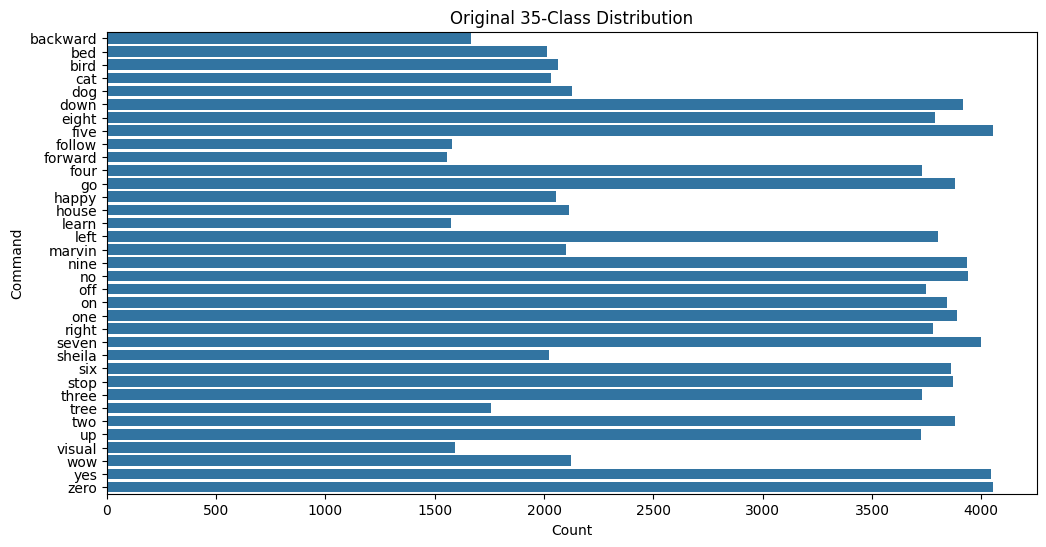

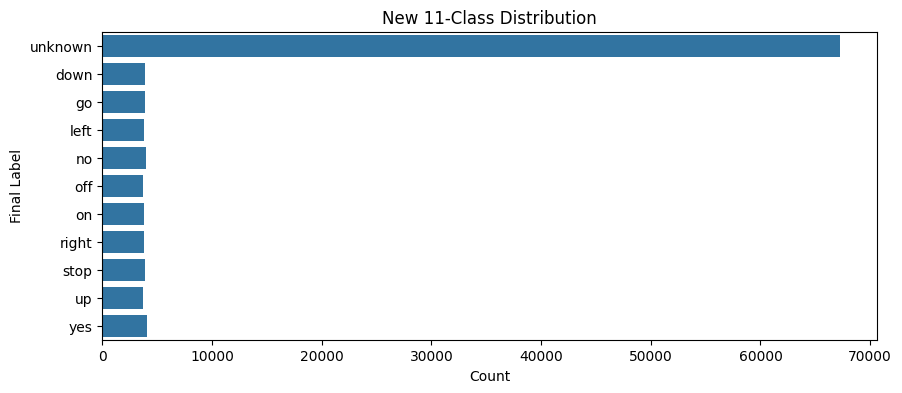

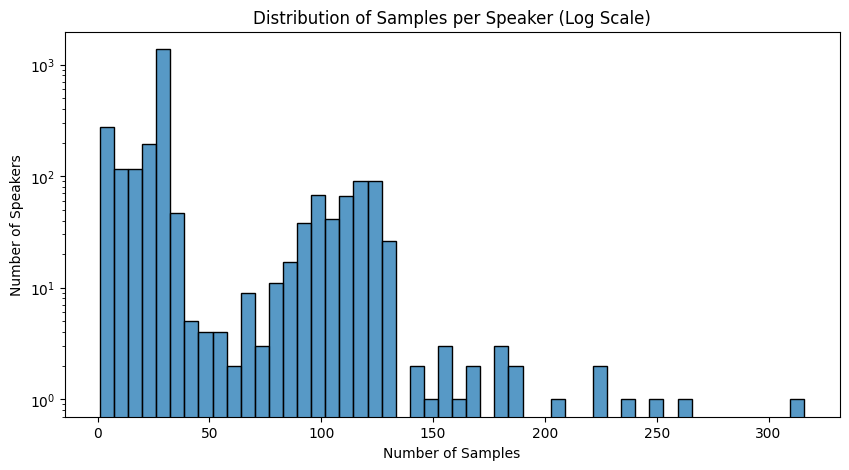

count    2618.000000
mean       40.423606
std        36.915312
min         1.000000
25%        25.000000
50%        30.000000
75%        30.000000
max       316.000000
Name: count, dtype: float64
Generating EDA Plot 3: Feature Distribution by Class (Boxplots)


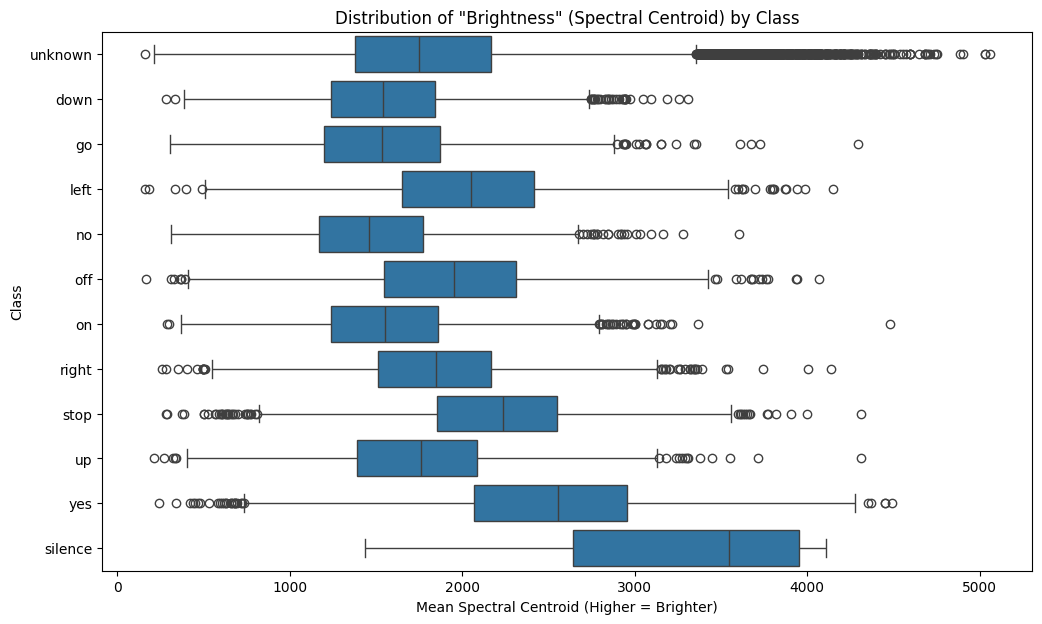

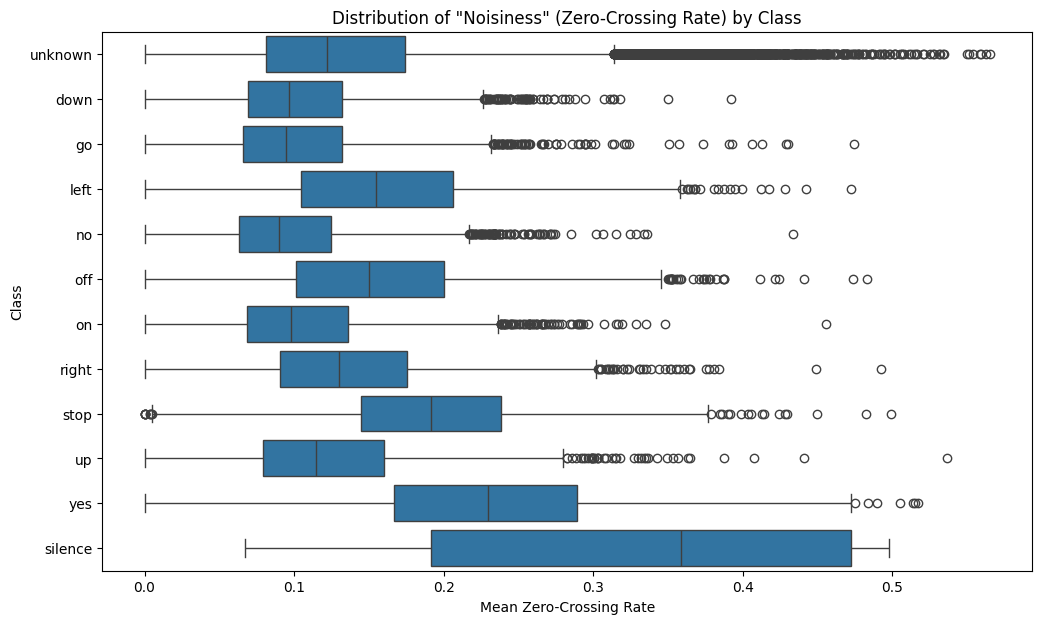

Generating EDA Plot 4: Feature Correlation Heatmap


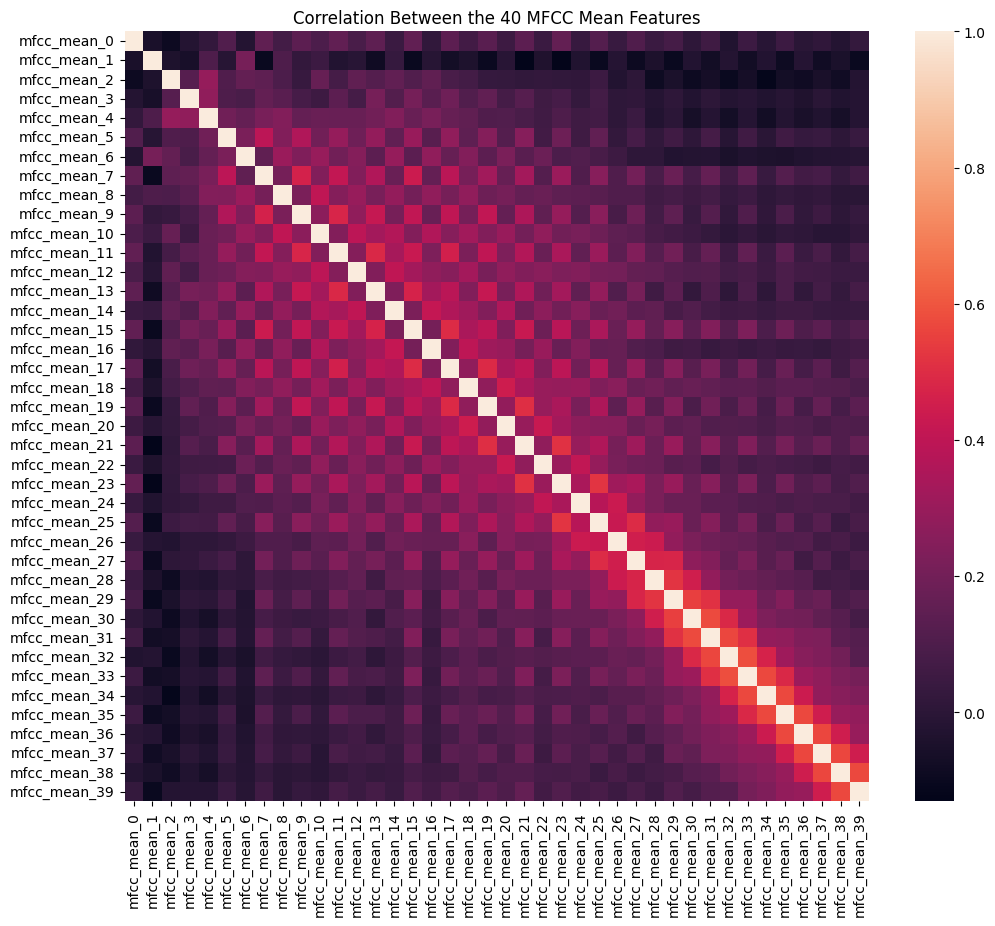

In [5]:

# EDA figures
# 35-Class Distribution
plt.figure(figsize=(12, 6))
sns.countplot(y=df['label'])
plt.title('Original 35-Class Distribution')
plt.xlabel('Count')
plt.ylabel('Command')
plt.show()

# 11-Class Distribution
plt.figure(figsize=(10, 4))
sns.countplot(y=df['final_label'])
plt.title('New 11-Class Distribution')
plt.xlabel('Count')
plt.ylabel('Final Label')
plt.show()

# Samples per Speaker
speaker_counts = df['speaker_id'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(speaker_counts, bins=50)
plt.title('Distribution of Samples per Speaker (Log Scale)')
plt.xlabel('Number of Samples')
plt.ylabel('Number of Speakers')
plt.yscale('log')
plt.show()
print(speaker_counts.describe())

# Boxplot of Features by Class
print("Generating EDA Plot 3: Feature Distribution by Class (Boxplots)")

# "Brightness" - Spectral Centroid
plt.figure(figsize=(12, 7))
sns.boxplot(data=plot_df, x='spec_centroid_mean', y='label')
plt.title('Distribution of "Brightness" (Spectral Centroid) by Class')
plt.xlabel('Mean Spectral Centroid (Higher = Brighter)')
plt.ylabel('Class')
plt.show()

# "Noisiness" Zero-Crossing Rate
plt.figure(figsize=(12, 7))
sns.boxplot(data=plot_df, x='zcr_mean', y='label')
plt.title('Distribution of "Noisiness" (Zero-Crossing Rate) by Class')
plt.xlabel('Mean Zero-Crossing Rate')
plt.ylabel('Class')
plt.show()

# Feature Correlation-
print("Generating EDA Plot 4: Feature Correlation Heatmap")
# 40 MFCC means
mfcc_mean_features = plot_df[[f'mfcc_mean_{i}' for i in range(40)]]

plt.figure(figsize=(12, 10))
sns.heatmap(mfcc_mean_features.corr())
plt.title('Correlation Between the 40 MFCC Mean Features')
plt.show()
